In [1]:
# Load all required Libraries
import pandas as pd
import transformers, torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset

from pymilvus import MilvusClient, FieldSchema, CollectionSchema, DataType, Collection

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Read Passages from the Datasets and Drop rows if they are NA or empty

In [2]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")

print(passages.shape)
passages.head()

(3200, 1)


,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


# Do EDA on the passage dataset
- You can try to find the maximum and minimum length of the passages before indexing (just a direction)

Character length stats:
count        3200.0
mean     389.848125
std      348.368869
min             1.0
25%           108.0
50%           299.0
75%           574.0
max          2515.0
Name: char_len, dtype: Float64

Word length stats:
count    3200.000000
mean       62.103750
std        55.422049
min         1.000000
25%        17.000000
50%        48.000000
75%        92.000000
max       425.000000
Name: word_len, dtype: float64

Shortest passage:
 |

Longest passage:
 As Ford approached his ninetieth year, he began to experience significant health problems associated with old age. He suffered two minor strokes at the 2000 Republican National Convention, but made a quick recovery.  Gerald Ford recovering after strokes. BBC, August 2, 2000.  Retrieved on December 31, 2006.  In January 2006, he spent 11 days at the Eisenhower Medical Center near his residence at Rancho Mirage, California, for treatment of pneumonia.  Former President Ford, 92, hospitalized with pneumonia. Associated Pre

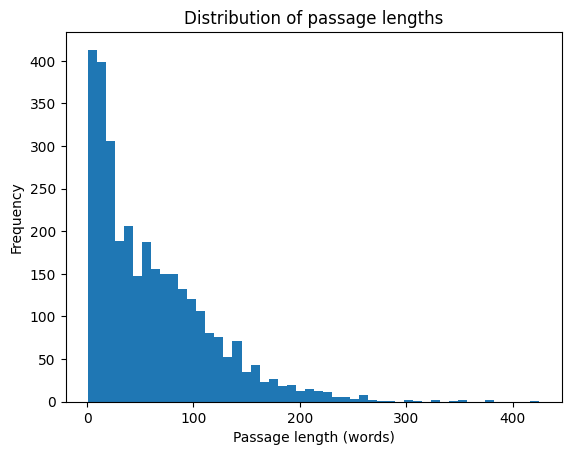

In [3]:
# Code for EDA

# 1. Compute length (number of characters and tokens)
passages["char_len"] = passages["passage"].str.len()
passages["word_len"] = passages["passage"].str.split().str.len()

# 2. Basic stats
print("Character length stats:")
print(passages["char_len"].describe())

print("\nWord length stats:")
print(passages["word_len"].describe())

# 3. Find min and max
min_passage = passages.loc[passages["char_len"].idxmin(), "passage"]
max_passage = passages.loc[passages["char_len"].idxmax(), "passage"]

print("\nShortest passage:\n", min_passage)
print("\nLongest passage:\n", max_passage)

# 4. Plot distribution (optional, needs matplotlib)
import matplotlib.pyplot as plt

plt.hist(passages["word_len"], bins=50)
plt.xlabel("Passage length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of passage lengths")
plt.show()


In [4]:
# 5. cleaning before embeddings
# Drop NA
s = passages["passage"].dropna().astype(str)

# Normalize whitespace:
# - convert non-breaking space (NBSP, \u00A0) to normal space
# - collapse multiple spaces/tabs/newlines into a single space
# - trim leading/trailing spaces
s = (
    s.str.replace("\u00A0", " ", regex=False)
     .str.replace(r"\s+", " ", regex=True)
     .str.strip()
)


# Filter obvious noise: keep >=5 words
s = s[s.str.split().str.len().ge(5)]

# Drop exact duplicates
s = s.drop_duplicates()

texts = s.tolist()
print(f"usable passages: {len(texts)}")

usable passages: 3014


In [5]:
# 6. lightweight word-based chunking for very long passages
MAX_LEN = 300      # trigger threshold (words)
CHUNK = 220        # chunk size (words)
OVERLAP = 50       # overlap (words)

texts_for_index = []
for t in texts:
    words = t.split()
    if len(words) <= MAX_LEN:
        texts_for_index.append(t)
    else:
        step = max(CHUNK - OVERLAP, 1)
        for i in range(0, len(words), step):
            piece = " ".join(words[i:i+CHUNK])
            if not piece: break
            texts_for_index.append(piece)
            if i + CHUNK >= len(words): break

print(f"passages after optional chunking: {len(texts_for_index)}")

passages after optional chunking: 3026


# Tokenize Text and Generate Embeddings using Sentence Transformers

In [6]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode Text
embeddings = embedding_model.encode(
    texts_for_index,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # inner product ≈ cosine
).astype("float32")

print("embeddings shape:", embeddings.shape)


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

embeddings shape: (3026, 384)


# Create Milvus Client and Insert your Embeddings to your DB
- Make sure you define a schema for your collection (Points will be deducted if you fail to define a proper schema with ids, passage text, embedding)

In [7]:
# Create a Milvus client connection
client = MilvusClient("rag_wikipedia_mini.db")

/Users/yisyuan/venvs/rag-pip/lib/python3.12/site-packages/milvus_lite/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [8]:
dim = int(embeddings.shape[1])

# Build a collection schema with three fields: id / passage / embedding

# Primary key column: INT64, user-managed IDs
schema = client.create_schema(auto_id=False, description="RAG mini wikipedia passages")
schema.add_field(
    field_name="id",       
    datatype=DataType.INT64,       
    is_primary=True, 
    auto_id=False
)
# Raw text column: VARCHAR; max_length picked from EDA (max ≈ 2515 chars) with safety buffer
schema.add_field(
    field_name="passage",
    datatype=DataType.VARCHAR,
    max_length=4096
)
# Embedding column: FLOAT_VECTOR with the dimension detected above
schema.add_field(
    field_name="embedding",
    datatype=DataType.FLOAT_VECTOR,
    dim=dim)

{'auto_id': False, 'description': 'RAG mini wikipedia passages', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': False}, {'name': 'passage', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 4096}}, {'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}], 'enable_dynamic_field': False}

In [9]:
# Create the collection named "rag_mini" using the schema defined above
COLL = "rag_mini"
if COLL in client.list_collections():
    client.drop_collection(COLL) # drop first to avoid schema conflicts during iteration
client.create_collection(collection_name=COLL, schema=schema)

**Convert your Pandas Dataframe to a list of dictionaries**
- The Dictionary at least have 3 keys [id, passage, embedding]

In [10]:
rag_data = [
    {
    "id": int(i),
    "passage": texts_for_index[i],
    "embedding": embeddings[i].tolist(),
}
    for i in range(len(texts_for_index))
]
len(rag_data)

3026

In [11]:
# Code to insert the data to your DB
res = client.insert(collection_name="rag_mini", data=rag_data)
print(res)

{'insert_count': 3026, 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,

- Do a Sanity Check on your database 

**Do not delete the below line during your submission**

In [12]:
print("Entity count:", client.get_collection_stats("rag_mini")["row_count"])
print("Collection schema:", client.describe_collection("rag_mini"))

Entity count: 3026
Collection schema: {'collection_name': 'rag_mini', 'auto_id': False, 'num_shards': 0, 'description': 'RAG mini wikipedia passages', 'fields': [{'field_id': 100, 'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'params': {}, 'is_primary': True}, {'field_id': 101, 'name': 'passage', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 4096}}, {'field_id': 102, 'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}], 'functions': [], 'aliases': [], 'collection_id': 0, 'consistency_level': 0, 'properties': {}, 'num_partitions': 0, 'enable_dynamic_field': False}


# Steps to Fetch Results
- Read the Question Dataset
- Clean the Question Dataset if necessary (Drop Questions with NaN etc.)
- Convert Each Query to a Vector Embedding (Use the same embedding model you used to embed your document)
- Try for a Single Question First
- Load Collection into Memory after creating Index for Search on your embedding field (This is an essential step before you can search in your db)
- Search and Fetch Top N Results

In [13]:
queries = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
print(queries.shape)
queries.head(10)

(918, 2)


,question,answer
id,,
0,Was Abraham Lincoln the sixteenth President of...,yes
2,Did Lincoln sign the National Banking Act of 1...,yes
4,Did his mother die of pneumonia?,no
6,How many long was Lincoln's formal education?,18 months
8,When did Lincoln begin his political career?,1832
10,What did The Legal Tender Act of 1862 establish?,"the United States Note, the first paper curren..."
12,Who suggested Lincoln grow a beard?,11-year-old Grace Bedell
14,When did the Gettysburg address argue that Ame...,1776
16,Did Lincoln beat John C. Breckinridge in the 1...,yes


In [14]:
# cleaning before embedding
qdf = queries.dropna(subset=["question"]).copy()

# to string + normalize whitespace + trim 
qdf["question"] = (
    qdf["question"].astype(str)
    .str.replace("\u00A0", " ", regex=False)       # NBSP -> space
    .str.replace(r"\s+", " ", regex=True)          # collapse spaces/tabs/newlines
    .str.strip()
)

# filter short/low-signal questions (keep >=5 chars AND >=3 words)
qdf = qdf[qdf["question"].str.len().ge(5) & qdf["question"].str.split().str.len().ge(3)]

# drop exact duplicates (keep first) and reindex
qdf = qdf.drop_duplicates(subset=["question"]).reset_index(drop=True)

print(f"usable questions: {len(qdf)}")

# get lists for embedding/eval
questions = qdf["question"].tolist()
answers   = qdf["answer"].tolist() if "answer" in qdf.columns else None

usable questions: 917


In [15]:
# Embedding - Try for a Single Question First
query = questions[0]                 # Your single query

query_embedding = embedding_model.encode(
    [query],                   
    normalize_embeddings=True,  # cosine ≈ inner product (IP)
    convert_to_numpy=True
).astype("float32")


print(query_embedding.shape)

(1, 384)


#### Create Index on the embedding column on your DB

In [16]:
index_params = MilvusClient.prepare_index_params()

# Add an index on the embedding field
index_params.add_index(
    field_name="embedding",
    index_type="IVF_FLAT",
    metric_type="IP"
)

# Create the index
try:
    client.create_index(
        collection_name="rag_mini",
        index_params=index_params
    )
except Exception as e:
    print(f"Index creation result: {e}")

# Load collection into memory (required for search)
client.load_collection("rag_mini")
print("Collection loaded into memory")

Collection loaded into memory


In [17]:
# Search the db with your query embedding
output_ = client.search(
    collection_name="rag_mini",
    data=query_embedding.tolist(),   #(1, 384) -> list
    anns_field="embedding",
    limit=1,  # top 1
    output_fields=["passage"],
    search_params= {"metric_type": "IP", "params": {"nprobe": 32}} 
)

for i, hit in enumerate(output_[0], 1):
    print(i, hit["id"], round(hit["distance"], 4), "|", hit["entity"]["passage"])

1 265 0.584 | Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in reference to the anti-expansion sentiments he had then expressed. Doris Kearns Goodwin, Team of Rivals: The Political Genius of Abraham Lincoln (2005) p. 91. Holzer pg. 232. Writing of the Cooper Union speech, Holzer notes, "Cooper Union proved a unique confluence of political culture, rhetorical opportunity, technological innovation, and human genius, and it brought Abraham Lincoln to the center stage of American politics at precisely the right time and place, and with pr

In [18]:
print(f"Question: {query}")
print(f"Ground truth answer: {answers[0]}")

Question: Was Abraham Lincoln the sixteenth President of the United States?
Ground truth answer: yes


## Now get the Context 
- Initially use the first passage ONLY as your context
- In Later Experiments, you must try at least 2 different passage selection strategies (Top 3 / Top 5 / Top 10) and pass to your prompt

In [19]:
# === Build context from search results ===
def build_context(search_output, k, max_chars=1200):
    """Join top-k passages into a single context string."""
    hits = search_output[0][:k]
    chunks = []
    for i, h in enumerate(hits, 1):
        passage = h["entity"]["passage"]
        chunks.append(f"[{i}] {passage[:max_chars]}")
    return "\n\n".join(chunks)
    
context = build_context(output_, k=1)
print(context)

[1] Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in reference to the anti-expansion sentiments he had then expressed. Doris Kearns Goodwin, Team of Rivals: The Political Genius of Abraham Lincoln (2005) p. 91. Holzer pg. 232. Writing of the Cooper Union speech, Holzer notes, "Cooper Union proved a unique confluence of political culture, rhetorical opportunity, technological innovation, and human genius, and it brought Abraham Lincoln to the center stage of American politics at precisely the right time and place, and with precisely th

**Develop your Prompt**

In [30]:
# 1. Clear Prompt 
prompt_clear = (
    """
    You are a helpful assistant that answers questions ONLY using the provided passages. 
    If any part is unsupported, respond with exactly: "Unable to verify from provided passages."
    Use plain, neutral language. 
    Do not add extra background, examples, or definitions unless they appear word-for-word in the passages. 
    Keep answers concise and factual, ≤60 words. 
    """
)

# 2. Few-shots Prompt
prompt_fewshots = (
    """
    You are a helpful assistant that answers questions ONLY using the provided passages. 
    If any part is unsupported, respond with exactly: "Unable to verify from provided passages."
    Use plain, neutral language. 
    Do not add extra background, examples, or definitions unless they appear word-for-word in the passages. 
    Keep answers concise and factual, ≤60 words. 
    
    Follow the examples exactly.
    
    Example 1
    Q: In what year was Company A founded?
    Passages:
    [1] Company A was founded in 2004.
    A:
    Founded in 2004. [1]
    
    Example 2
    Q: Who is the CEO of Company B?
    Passages:
    [1] Company B was founded in 1999.
    [2] Its current CEO is Jane Smith.
    A:
    Jane Smith is the CEO. [2]
    
    Example 3 
    Q: What is Company C's market share in 2023?
    Passages:
    [P1] Company C is a technology company headquartered in London.
    A:
    Unable to verify from provided passages."""
)

prompt_clear = f"""{prompt_clear}\n\nContext: {context}: \n\nQuestion: {query} """
prompt_fewshots = f"""{prompt_fewshots}\n\nContext: {context}: \n\nQuestion: {query} """
print(prompt_clear)


    You are a helpful assistant that answers questions ONLY using the provided passages. 
    If any part is unsupported, respond with exactly: "Unable to verify from provided passages."
    Use plain, neutral language. 
    Do not add extra background, examples, or definitions unless they appear word-for-word in the passages. 
    Keep answers concise and factual, ≤60 words. 
    

Context: [1] Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in reference to the anti-expansion sentiments he had then expressed. Doris Kearns Goodwin, Tea

# RAG Response for a Single Query

In [21]:
# Load the LLM Model you want to use
from transformers import pipeline
qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-small", device = "cpu")

Device set to use cpu


In [22]:
# Generate answer
response = qa_pipeline(
    prompt_clear, 
    max_new_tokens=60, 
    do_sample=False,
    num_beams=3,
    no_repeat_ngram_size=3
)

# Decode and extract answer.
rag_answer = response[0]["generated_text"]
print("RAG Answer:", rag_answer)

RAG Answer: yes.


# Generate Responses for all the Queries in the Dataset

In [23]:
# --- 1. Create index (only once, before batch search) ---
index_params = MilvusClient.prepare_index_params()
index_params.add_index(
    field_name="embedding",
    index_type="IVF_FLAT",
    metric_type="IP"
)

try:
    client.create_index(
        collection_name="rag_mini",
        index_params=index_params
    )
except Exception as e:
    print(f"Index creation result: {e}")

# Load collection into memory
client.load_collection("rag_mini")
print("Collection loaded into memory")

Collection loaded into memory


In [26]:
# --- 2. Embedding all questions ---
q_embeddings = embedding_model.encode(
    questions,
    normalize_embeddings=True,
    convert_to_numpy=True
).astype("float32")

print("Embeddings shape:", q_embeddings.shape)

Embeddings shape: (917, 384)


In [27]:
# --- 3. Search loop for all queries ---
all_results = []
for i, (q, q_emb) in enumerate(zip(questions, q_embeddings), 1):
    output_ = client.search(
        collection_name="rag_mini",
        data=[q_emb.tolist()],   
        anns_field="embedding",
        limit=1,  # Top-1
        output_fields=["passage"],
        search_params={"metric_type": "IP", "params": {"nprobe": 32}}
    )
    hits = [
        {
            "id": h["id"],
            "score": float(h["distance"]),
            "passage": h["entity"]["passage"]
        }
        for h in output_[0]
    ]

    all_results.append({
        "question": q,
        "ground_truth": answers[i-1] if answers else None,
        "hits": hits
    })

    # sanity check
    if i <= 3:
        print(f"\nQ{i}: {q}")
        for j, h in enumerate(hits, 1):
            print(f"{j}. {h['score']:.4f} | {h['passage'][:100]}...")

print(f"\nTotal queries processed: {len(all_results)}")


Q1: Was Abraham Lincoln the sixteenth President of the United States?
1. 0.5840 | Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United Sta...

Q2: Did Lincoln sign the National Banking Act of 1863?
1. 0.6409 | Lincoln believed in the Whig theory of the presidency, which left Congress to write the laws while h...

Q3: Did his mother die of pneumonia?
1. 0.4833 | An autopsy performed after his death revealed grave problems with his stomach and other organs of hi...

Total queries processed: 917


In [28]:
from transformers import pipeline
qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-small", device = "cpu")
preds, refs = [], []
total = len(all_results)
for i, item in enumerate(all_results[:], 1):
    q = item["question"]
    gt = item["ground_truth"]
    # top-1 passage as context
    ctx = f"[1] {item['hits'][0]['passage'][:600]}"
    out = qa_pipeline(
        prompt_clear, 
        max_new_tokens=60, 
        do_sample=False,
        num_beams=3,
        no_repeat_ngram_size=3
    )[0]["generated_text"].strip()

    preds.append({"id": str(i), "prediction_text": out})
    if gt is not None:
        refs.append({"id": str(i), "answers": {"text": [str(gt)], "answer_start": [0]}})

    if i <= 10:
        print(f"\nQ{i}: {q}")
        print("Pred:", out)
        print("GT  :", gt)
        
    if i % 50 == 0 or i == total:
        print(f"[{i}/{total}] processed", flush=True)
        
print(f"\nGenerated answers: {len(preds)}")

Device set to use cpu



Q1: Was Abraham Lincoln the sixteenth President of the United States?
Pred: yes.
GT  : yes

Q2: Did Lincoln sign the National Banking Act of 1863?
Pred: yes.
GT  : yes

Q3: Did his mother die of pneumonia?
Pred: yes.
GT  : no

Q4: How many long was Lincoln's formal education?
Pred: yes.
GT  : 18 months

Q5: When did Lincoln begin his political career?
Pred: yes.
GT  : 1832

Q6: What did The Legal Tender Act of 1862 establish?
Pred: yes.
GT  : the United States Note, the first paper currency in United States history

Q7: Who suggested Lincoln grow a beard?
Pred: yes.
GT  : 11-year-old Grace Bedell

Q8: When did the Gettysburg address argue that America was born?
Pred: yes.
GT  : 1776

Q9: Did Lincoln beat John C. Breckinridge in the 1860 election?
Pred: yes.
GT  : yes

Q10: Was Abraham Lincoln the first President of the United States?
Pred: yes.
GT  : No
[50/917] processed
[100/917] processed
[150/917] processed
[200/917] processed
[250/917] processed
[300/917] processed
[350/917] proc

# Finding out the Basic QA Metrics (F1 score, EM score)

In [29]:
if refs:
    import evaluate
    metric = evaluate.load("squad")
    results = metric.compute(predictions=preds, references=refs)
    print("\nEvaluation Results:", results)
else:
    print("\nNo ground-truth answers found; skipped scoring.")


Evaluation Results: {'exact_match': 36.31406761177754, 'f1': 36.617853248169496}


## Try different prompt - Few shots

In [32]:
from transformers import pipeline
qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-small", device = "cpu")
preds, refs = [], []
total = len(all_results)
for i, item in enumerate(all_results[:], 1):
    q = item["question"]
    gt = item["ground_truth"]
    # top-1 passage as context
    ctx = f"[1] {item['hits'][0]['passage'][:10]}"
    out = qa_pipeline(
        prompt_fewshots, 
        max_new_tokens=60, 
        do_sample=False,
        num_beams=3,
        no_repeat_ngram_size=3
    )[0]["generated_text"].strip()

    preds.append({"id": str(i), "prediction_text": out})
    if gt is not None:
        refs.append({"id": str(i), "answers": {"text": [str(gt)], "answer_start": [0]}})

    if i <= 10:
        print(f"\nQ{i}: {q}")
        print("Pred:", out)
        print("GT  :", gt)
        
    if i % 50 == 0 or i == total:
        print(f"[{i}/{total}] processed", flush=True)
        
print(f"\nGenerated answers: {len(preds)}")

if refs:
    metric = evaluate.load("squad")
    results = metric.compute(predictions=preds, references=refs)
    print("\nEvaluation Results:", results)
else:
    print("\nNo ground-truth answers found; skipped scoring.")

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors



Q1: Was Abraham Lincoln the sixteenth President of the United States?
Pred: A: yes
GT  : yes

Q2: Did Lincoln sign the National Banking Act of 1863?
Pred: A: yes
GT  : yes

Q3: Did his mother die of pneumonia?
Pred: A: yes
GT  : no

Q4: How many long was Lincoln's formal education?
Pred: A: yes
GT  : 18 months

Q5: When did Lincoln begin his political career?
Pred: A: yes
GT  : 1832

Q6: What did The Legal Tender Act of 1862 establish?
Pred: A: yes
GT  : the United States Note, the first paper currency in United States history

Q7: Who suggested Lincoln grow a beard?
Pred: A: yes
GT  : 11-year-old Grace Bedell

Q8: When did the Gettysburg address argue that America was born?
Pred: A: yes
GT  : 1776

Q9: Did Lincoln beat John C. Breckinridge in the 1860 election?
Pred: A: yes
GT  : yes

Q10: Was Abraham Lincoln the first President of the United States?
Pred: A: yes
GT  : No
[50/917] processed
[100/917] processed
[150/917] processed
[200/917] processed
[250/917] processed
[300/917] proc

# Advanced Evaluation using RAGAs

In [ ]:
data = {
    "question": ... ,                     # Question
    "answer": ... ,                       # Generated Answer
    "contexts": ... ,                     # Context you pass in. You can just use top-1 here
    "ground_truths": ...                  # Reference Answer in the dataset (Human annotated)
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [ ]:
# Pass the dataset above to the evaluate method in RAGAs
# Your code here
...